In [2]:
import numpy as np
from matplotlib import pyplot as plt
import math
from scipy import interpolate


def ode_model_pressure(t, P, q, a, b, P0, c, dqdt):
	''' Return the derivative dP/dt at time, t, for given parameters.
		Parameters:
		-----------
		t : float
			Independent variable.
		P : float
			Dependent variable.
		q : float
			Source/sink rate.
		a : float
			Source/sink strength parameter.
		b : float
			Recharge strength parameter.
		P0 : float
			Ambient value of dependent variable.
		c : float
			slow drainage parameter
		dqdt: float
			mass rate differential
		Returns:
		--------
		dxdt : float
			Derivative of dependent variable with respect to independent variable.
		Notes:
		------
		None
		Examples:
		---------
		>>> ode_model_pressure(0, 1, 2, 3, 4, 5, 6, 7)
		-32
	'''
	
	dPdt=-a*q-b*(P-P0)-c*dqdt
	return dPdt

def ode_model_concentration(t,C,q,M,a,b,P,P0,d,C0):
	'''returns dCdt at given time and parameters
	
	Parameters:
	t: float
	   Independent variable
	C: concentration 
	   Dependent variable
	q: float
	   Injection rate of CO2
	M: float
	   Ambient mass of the system 
	a: float
	   Source/sink strength parameter
	b: float 
	   Recharge strength parameter.
	P: float
	   Pressure of the system at time t
	P0: float
	   Ambient pressure of the system 
	d: float
	   CO2 reaction rate 
	C0: float
		Ambient concentration of the system
	
	Outputs:
	dCdt: float
		  rate of change of concentration of CO2 at time t 
	Notes: 
	N/A
	'''

	if P>P0:
		return (1-C)*q/(M)-d*(C-C0)
	else:
		return (1-C)*q/(M)-b*(P-P0)*(C0-C)/(M*a)-d*(C-C0)

def solve_ode_concentration(f, t0, t1, dt, x0, q, P, pars):
	'''
	solve the concentration ODE by using improved euler on ode_model_concentration()
	Parameters:
	f : callable
			Function that returns dxdt given variable and parameter inputs.
	t0 : float
		Initial time of solution.
	t1 : float
		Final time of solution.
	dt : float
		Time step length.
	x0 : floar
		Initial value
	q : array-like 
		interpolated qCO2
	P : array-like
		solved P
	pars: array-like
		parameter inputs
	Outputs:
	t: array-like
	   time
	x: array-like
	   concentration
	Notes: 
	Assume the parameters in pars are in this order
		1. q: injection rate [kg/s]
		2. M: mass of the system []
		3. a: source/sink coefficient 
		4. b: recharge coefficient 
		5. P: pressure of the system at time t []
		6. P0: Ambient pressure []
		7: d: CO2 reaction rate coefficient []
		8: C0: initial concentration of CO2 
	'''

	#Allocate time and concentration array 
	nx = int(np.ceil((t1-t0)/dt))
	t = t0+np.arange(nx+1)*dt
	x=0.*t
	x[0]=x0

	#Set up initial injection rate and pressure 
	pars[0]=q[0]
	pars[4]=P[0]
	
	#Improved Euler 
	for i in range(1,nx+1):
		x_predict=x[i-1]+dt*f(t[i-1],x[i-1],*pars)
		x[i]=x[i-1]+(f(t[i-1],x[i-1],*pars)+f(t[i-1]+dt,x_predict,*pars))*dt/2

		#Update the parameters 
		pars[0]=q[i]
		pars[4]=P[i]

	return t,x

def solve_ode(f, t0, t1, dt, P, pars):
	''' Solve the pressure ODE numerically.
		Parameters:
		-----------
		f : callable
			Function that returns dxdt given variable and parameter inputs.
		t0 : float
			Initial time of solution.
		t1 : float
			Final time of solution.
		dt : float
			Time step length.
		P : float
			Initial value of solution.
		pars : array-like
			List of parameters passed to ODE function f.
		Returns:
		--------
		t : array-like
			Independent variable solution vector.
		x : array-like
			Dependent variable solution vector.
		Notes:
		------
		ODE should be solved using the Improved Euler Method. 
		Function q(t) should be hard coded within this method. Create duplicates of 
		solve_ode for models with different q(t).
		Assume that ODE function f takes the following inputs, in order:
			1. independent variable
			2. dependent variable
			3. forcing term, q
			4. all other parameters
		
		The parameters are in order:
			1. q: forcing term (array-like)
			2. a: source/sink parameter
			3. b: recharge parameter
			4. P0: initial pressure
			5. c: slow drainage
			6. dqdt: rate of change of forcing terms
	'''

	#Pre allocate time 
	nx = int(np.ceil((t1-t0)/dt))
	t = t0+np.arange(nx+1)*dt

	#Preallocate value for first iteration
	x=0.*t
	x[0]=P
	q=pars[0]
	dqdt=pars[5]

	#Loop 
	for i in range(1,nx+1):
		#Update parameters
		pars[0]=q[i-1]
		pars[5]=dqdt[i-1]

		#Prediction step 
		x_predict=x[i-1]+dt*f(t[i-1],x[i-1],*pars)

		#Correction
		x[i]=x[i-1]+(f(t[i-1],x[i-1],*pars)+f(t[i-1]+dt,x_predict,*pars))*dt/2
	return t,x

def pressure_analytical(t,P0,a,b,c):
	'''returns the analytical solution of the pressure model
	
	Parameters: 
	t: array-like
		time
	P0: float
		ambient pressure 
	a: float
		source/sink coefficient
	b: float
		recharge coefficient
	c: float
		slow drainage coefficient 
	
	Outputs: 
	P: array-like
		pressure evaluated at time t
	
	Notes: 
	_P and t have the same size 
	Assume that q=50 is constant --> dqdt=0
	
	'''

	#Modify time array so it starts at 0
	t=t-t[0]
	
	#Allocate P array
	P=0.*t
	P[0]=P0
	#Evaluating Pressure using analytical solution 
	for i in range(1,len(t)):
		P[i]=-a*150/b*(1-np.exp(-b*t[i]))+P0
	return P

def concentration_analytical(t,q,M,a,b,P,P0,d,C0):
	'''
	returns the analytical solution for concentration model 
	Parameters: 
	t: array-like
		time 
	q: array-like
		injection rate 
	M: float
		initial mass of the system 
	a: float
		parameter a got from pressure model
	b: float
		papramter b got from pressure model
	P: array-like
		pressure at time t 
	P0: float
		ambient pressure of the system 
	d: float
		parameter d 
	C0: float
		ambient CO2 concentration pf the system
	Outputs: 
	C: array-like
		analytical solution of the concentration model  
	
	'''
	#Modify time array 
	t=t-t[0]
	
	#pre-allocate time array 
	C=0.*t
	for i in range(len(t)):
		if P[i]>P0:
			S=q[i]/M+d
			R=q[i]/M+d*C0
		else: 
			S=q[i]/M-b*(P[i]-P0)/(a*(M))+d
			R=q[i]/M-C0*(b*(P[i]-P0)/(a*(M))-d)
		C[i]=R/S+(C0-R/S)*np.exp(-S*t[i])
	
	return C



def construct_samples_pressure(mean,covariance,N_samples):
	''' This function constructs samples from a multivariate normal distribution
		fitted to the data.
		Parameters:
		-----------
		a : array-like
			Vector of 'a' parameter values.
		b : array-like
			Vector of 'b' parameter values.
		c : array-like
			Vector of 'c' parameter values.
		P : array-like
			Posterior probability distribution.
		N_samples : int
			Number of samples to take.
		Returns:
		--------
		samples : array-like
			parameter samples from the multivariate normal
		Notes:
		-----------
		263 Lab
	'''

	# compute properties (fitting) of multivariate normal distribution
	# mean = a vector of parameter means
	# covariance = a matrix of parameter variances and correlations
	#A, B, C = np.meshgrid(a,b,c,indexing='ij')
	#mean, covariance = fit_mvn([A,B,C], P)

	# 1. create samples using numpy function multivariate_normal (Google it)
	samples=np.random.multivariate_normal(mean, covariance, size=N_samples)

	return samples

def model_ensemble_pressure(samples,q_pressure,dqdt,P_t):
	''' Runs the model for given parameter samples and returns the results.
		Parameters:
		-----------
		samples : array-like
			parameter samples from the multivariate normal
		q_pressure: array-like
			net mass rate 
		dqdt: array-like
			rate of change of net mass rate
		P_t : float
			initial pressure
		
		Returns:
		-----------
		pressure: array-like
			list of results for given parameters samples
	'''

	#Create an empty list to store results
	pressure=[]
	# 3. for each sample, solve and plot the model  (see TASK 1)
	for a,b,c in samples:
		t,pm=solve_ode(ode_model_pressure,1968,2050,0.1,P_t,[q_pressure, a, b, 6.17, c, dqdt])
		pressure.append(pm)

	return pressure


def model_ensemble_concentration(samples,q_injection,pressure):
	''' Runs the concentration model for given parameter samples and gives the results.
		Parameters:
		-----------
		samples : array-like
			parameter samples from the multivariate normal
		q_injection: array-like
			injection rate
		pressure: array-like
			pressure of the system 
		Returns: 
		-----------
		concentration: array-like
			list of results for given parameter samples
	'''

	#Create a list to store results
	concentration=[]

	#for each sample, solve and store the result
	for M,d in samples:
		t,pm=t,pm=solve_ode_concentration(ode_model_concentration, 1980, 2050, 0.1, 0.03, q_injection, pressure, [q_injection[0],M,0.0019741,0.14734525,pressure[0],6.17,d,0.03])
		concentration.append(pm)
	
	return concentration

def construct_samples_concentration(mean,covariance,N_samples):
	''' This function constructs samples from a multivariate normal distribution
		fitted to the data.
		Parameters:
		-----------
		M : array-like
			Vector of 'M' parameter values.
		d : array-like
			Vector of 'd' parameter values.
		P : array-like
			Posterior probability distribution.
		N_samples : int
			Number of samples to take.
		Returns:
		--------
		samples : array-like
			parameter samples from the multivariate normal
	'''
	# compute properties (fitting) of multivariate normal distribution
	# mean = a vector of parameter means
	# covariance = a matrix of parameter variances and correlations

	#create samples using numpy function multivariate_normal (Google it)
	samples=np.random.multivariate_normal(mean, covariance, size=N_samples)
	
	return samples


# CALIBRATION ODE/SOLVE FUNCTIONS
#
# note:
# -----
# due to specific nature of the curve_fit function, different implementations of ode functions to take
# the required inputs and output the desired result were required so not as to destroy the rest of our code

import numpy as np


def cf_ode_model_pressure(P, q, dqdt, P0, a, b, c):
    ''' Return the derivative dP/dt at time, t, for given parameters.
        Parameters:
        -----------
        P : float
            Dependent variable.
        q : float
            Source/sink rate.
        dqdt: float
             Injection/Extraction rate differential.
        P0 : float
            Ambient value of dependent variable.
        a : float
            Source/sink strength parameter.
        b : float
            Recharge strength parameter.
        c : float
            Slow drainage parameter.
        Returns:
        --------
        dxdt : float
            Derivative of dependent variable with respect to independent variable.
        Notes:
        ------
        q = q_water - q_CO2
        Examples:
        ---------
        >>> ode_model_pressure(0, 1, 2, 3, 4, 5, 6, 7)
        -20
    '''

    return -a*q-b*(P-P0)-c*dqdt


def cf_ode_model_concentration(t, C, q_CO2, P, Mo, a, b, P0, d, C0):
    ''' Return dC/dt at given time, t, for given parameters.
    
    Parameters:
    -----------
    t: float
       Independent variable.
    C: concentration 
       Dependent variable.
    qCO2: float
       Injection rate of CO2.
    P: float
       Pressure of the system at time t.
    Mo: float
       Initial mass of the system (does not deviate that much)
    a: float
       Source/sink strength parameter.
    b: float 
       Recharge strength parameter.
    P0: float
       Initial/outside pressure of the system. 
    d: float
       CO2 reaction rate.
    C0: float
        Initial concentration of the system.
    
    Outputs:
    --------
    dCdt: float
        Rate of change of concentration of CO2 at time t.
    Notes:
    ------
    C0 is approximatley 3 wt% CO2 for Ohaaki Geothermal System (i.e C0 = 0.03).
    If P>Po the second term goes to zero, hence the if statement.
    '''

    # check condition and use appropriate version of model accordingly 
    if P>P0:
        return (1-C)*(q_CO2/Mo)-d*(C-C0)
    else:
        return (1-C)*(q_CO2/Mo)-(b/(a*Mo))*(P-P0)*(C0-C)-d*(C-C0)


def cf_solve_ode_concentration(t, t0, t1, dt, C0, q_CO2, P, M0, a, b, P0, d):
    ''' Solve the concentration ODE by using improved euler on ode_model_concentration()
    Parameters:
    -----------
        t : array-like
            Independent variable (time in years)
        t0 : float
            Initial time of solution.
        t1 : float
            Final time of solution.
        dt : float
            Time step length.
        C0 : float
            Initial value of solution.
        q_CO2 : array-like
            Injection rates.
        P : array-like
            Pressure values (from model).
        a : float
            Source/sink strength parameter.
        b : float
            Recharge strength parameter.
        P0 : float
            Initial pressure value.
        d : float
            CO2 reaction rate.
    Outputs:
    --------
    C: array-like
       Concentration solution array.
    Notes: 
    ------
        The t parameter input is not used- it's purpose is soley to ensure compatibility with
        curve_fit by absorbing the indeprendent variable input from curve_fit.
    '''

    # initialise
    steps = int(np.ceil((t1-t0)/dt))    # compute number of euler steps to take
    t = t0+np.arange(steps+1)*dt        # array of time values at which to evaluate
    C = 0.*t                            # solution array
    C[0] = C0                           # set intial solution value
    
    # improved Euler method
    for i in range(steps):

        # predictor step
        predict_C = C[i]+dt*cf_ode_model_concentration(t[i],C[i],q_CO2[i],P[i], M0, a, b, P0, d, C0)

        # corrector step
        C[i+1] = C[i]+(cf_ode_model_concentration(t[i],C[i],q_CO2[i],P[i], M0, a, b, P0, d, C0)+cf_ode_model_concentration(t[i+1],predict_C,q_CO2[i+1],P[i+1],M0, a, b, P0, d, C0))*dt/2

    return C


def cf_solve_ode_pressure(t, t0, t1, dt, P0, q, dqdt, a, b, c):
    ''' Solve the Pressure ODE numerically by using improved euler method on ode_model_pressure()
        Parameters:
        -----------
        t : array-like
            Independent variable (time in years)
        t0 : float
            Initial time of solution.
        t1 : float
            Final time of solution.
        dt : float
            Time step length.
        P0 : float
            Initial value of solution.
        q : array-like
            Injection/extraction rates.
        dqdt : array-like
            Injection/extraction rate derivatives.
        a : float
            Source/sink strength parameter.
        b : float
            Recharge strength parameter.
        c : float
            Slow drainage parameter.
        Returns:
        --------
        P : array-like
            Dependent variable solution vector.
        Notes:
        ------
        The t parameter input is not used- it's purpose is soley to ensure compatibility with
        curve_fit by absorbing the indeprendent variable input from curve_fit.
    '''
    
    # initialise 
    steps = int(np.ceil((t1-t0)/dt))    # compute number of euler steps to take
    t = t0+np.arange(steps+1)*dt        # array of time values at which to evaluate
    P = 0.*t                            # solution array
    P[0] = P0                           # set intial solution value
    
    # improved Euler method
    for i in range(steps):

        # predictor step
        predict_P = P[i]+dt*cf_ode_model_pressure(P[i],q[i],dqdt[i],P0,a, b, c)

        # corrector step
        P[i+1] = P[i]+(cf_ode_model_pressure(P[i],q[i],dqdt[i],P0,a, b, c)+cf_ode_model_pressure(predict_P,q[i+1],dqdt[i+1],P0,a, b, c))*dt/2

    return P



In [3]:
from matplotlib import pyplot as plt    
from numpy.linalg import norm
import numpy as np

def test_ode_pressure():
	#Test 1 
	dpdt = -32
	dpdt_2 = ode_model_pressure(0,1,2,3,4,5,6,7)
	assert dpdt == dpdt_2
	
	#Test 2
	dpdt = -92
	dpdt_2 = ode_model_pressure(10,9,8,7,6,5,4,3)
	assert dpdt == dpdt_2

def test_ode_concentration():
	#Test 1
	dcdt = 64+(10/3)
	dcdt_2 = ode_model_concentration(0,1,2,3,4,5,6,7,8,9)
	assert dcdt == dcdt_2

	#Test 2
	dcdt = -16-(64/7)
	dcdt_2 = ode_model_concentration(10,9,8,7,6,5,4,3,2,1)
	assert dcdt == dcdt_2

def test_pressure_solver():
	#Test 1: Increasing q
	B = [10,22.5,57.25]
	t,A = solve_ode(ode_model_pressure,0,2,1,10,[[1,2],2,3,4,5,[1,2]])
	for i in range(len(A)): 
		assert A[i]==B[i]
		

	#Test 2: decreasing q
	B = [40,200,997]
	t,A = solve_ode(ode_model_pressure,0,2,1,40,[[2,1],5,4,3,2,[1,2]])
	for i in range(len(A)): 
		assert A[i]==B[i]

	#Constant q
	B = [40, 203, 1018]
	t,A = solve_ode(ode_model_pressure,0,2,1,40,[[3,3],5,4,3,2,[0,0]])
	for i in range(len(A)): 
		assert A[i]==B[i]

	#Test time array
	time=np.array([0, 1, 2])
	t,A = solve_ode(ode_model_pressure,0,2,1,40,[[3,3],5,4,3,2,[0,0]])
	assert norm(t - time) < 1.e-10


def test_concentration_solver():
	#Test 1: constant q
	B = [1, -11, -65]
	t,A = solve_ode_concentration(ode_model_concentration,0,2,1,1,[1,1,1],[1,2,3],[1,1,1,1,1,4,1,3])
	for i in range(len(A)): 
		assert A[i]==B[i]
	

	#Test 2: q changes
	B = [2, -0.5, -20.75]
	t,A = solve_ode_concentration(ode_model_concentration,0,2,1,2,[3,2,3],[1,2,3],[1,1,1,1,1,4,1,3])
	for i in range(len(A)): 
		assert A[i]==B[i]

	#Test 3: decimal numbers
	B = [2, 2.36, 2.5812]
	t,A = solve_ode_concentration(ode_model_concentration,0,2,1,2,[1,1,1],[1,2,3],[1,10,0.1,0.1,1,4,1,3])
	for i in range(len(A)): 
		assert A[i]==B[i]

	#Test 4: decimal numbers 2
	B = [2, 0.125, -4.1875]
	t,A = solve_ode_concentration(ode_model_concentration,0,2,1,2,[1,0,1],[1,1,3],[2,2,0.1,0.1,1,5,1,3])
	for i in range(len(A)): 
		assert A[i]==B[i]

	#Test 5: decimal numbers 2
	time=np.array([0, 1, 2])
	t,A = solve_ode_concentration(ode_model_concentration,0,2,1,2,[1,0,1],[1,1,3],[2,2,0.1,0.1,1,5,1,3])
	assert norm(t-time) < 1.e-10

	#cf_solve_ode_pressure(t, t0, t1, dt, P0, q, dqdt, a, b, c)
	#cf_solve_ode_concentration(t, t0, t1, dt, C0, q_CO2, P, M0, a, b, P0, d):

def test_cf_ode_pressure():
	#Test 1 
	dpdt = -32
	dpdt_2 = cf_ode_model_pressure(1,2,7,5,3,4,6)
	assert dpdt == dpdt_2
	
	#Test 2
	dpdt = -92
	dpdt_2 = cf_ode_model_pressure(9,8,3,5,7,6,4)  
	assert dpdt == dpdt_2
	
def test_cf_ode_concentration():
	#Test 1
	dcdt = 64+(10/3)
	dcdt_2 = cf_ode_model_concentration(0,1,2,6,3,4,5,7,8,9) 
	assert dcdt == dcdt_2

	#Test 2
	dcdt = -16-(64/7)
	dcdt_2 = cf_ode_model_concentration(10,9,8,4,7,6,5,3,2,1) 
	assert dcdt == dcdt_2

def test_cf_pressure_solver():
	#Test 1: Increasing q
	B = [8,6.5,5.25]
	A = cf_solve_ode_pressure(0, 0, 2, 1, 8, [1,2,3], [1,1,1], 1, 1, 1)
	for i in range(len(A)): 
		assert A[i]==B[i]
		

	#Test 2: decreasing q
	B = [8, 8.5, 9]
	A = cf_solve_ode_pressure(0, 0, 2, 1, 8, [3,2,1], [-1,-1,-1], 1, 2, 3)
	for i in range(len(A)): 
		assert A[i]==B[i]

	#Constant q
	B = [8,8,8]
	A = cf_solve_ode_pressure(0, 0, 2, 1, 8, [3, 3, 3], [0, 0, 0], 2, 2, 2)
	for i in range(len(A)): 
		assert A[i]==B[i]

def test_cf_concentration_solver():
	#Test 1: constant q
	B = [2,1.925,1.865]
	A = cf_solve_ode_concentration(0, 0, 2, 1, 2, [3,3,3], [1,2,3], 10, 1, 1, 4, 1)
	for i in range(len(A)): 
		assert A[i]==B[i]
	

	#Test 2: q changes
	B = [4, 4.75, 6.625]
	A = cf_solve_ode_concentration(0, 0, 2, 1, 4, [1,2,4], [1,2,4], 2, 1, 2, 4, 1)
	for i in range(len(A)): 
		assert A[i]==B[i]

	#Test 3: decimal numbers
	B = [4, 5.6875, 13.17578125]
	A = cf_solve_ode_concentration(0, 0, 2, 1, 4, [1.5,3,4.5], [1,2,4], 2, 0.1, 0.2, 4, 1)
	for i in range(len(A)): 
		assert A[i]==B[i]

	#Test 4: decimal numbers 2
	B = [3.5, 3.5, 4.90625]
	A = cf_solve_ode_concentration(0, 0, 2, 1, 3.5, [1.5,3,4.5], [1,2,4], 2, 2, 1, 4, 1)
	for i in range(len(A)): 
		assert A[i]==B[i]

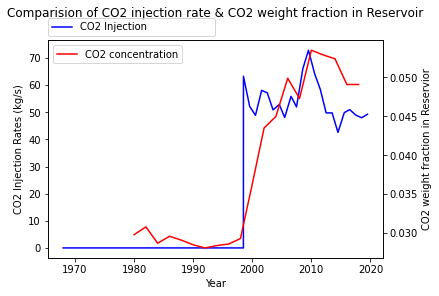

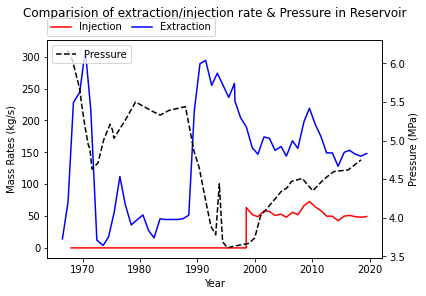

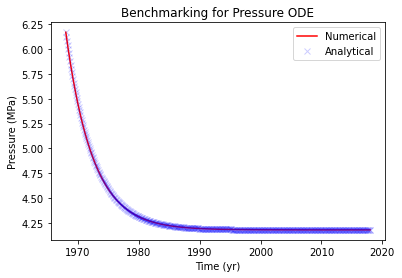

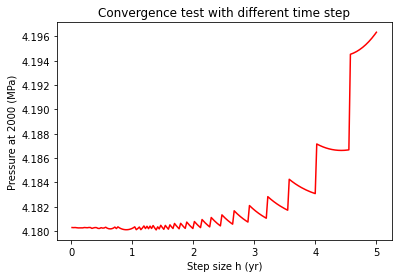

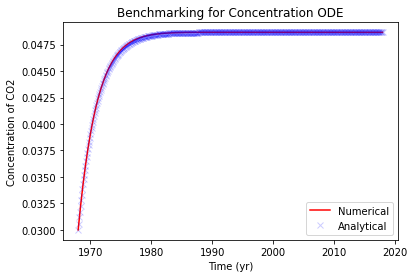

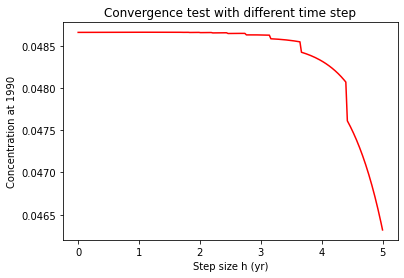

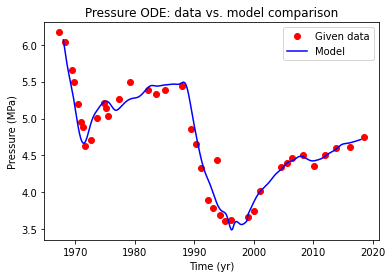

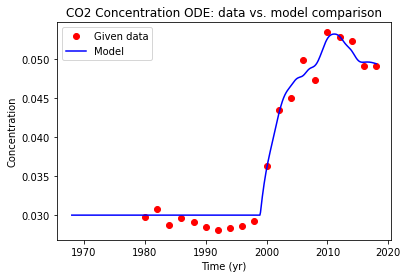

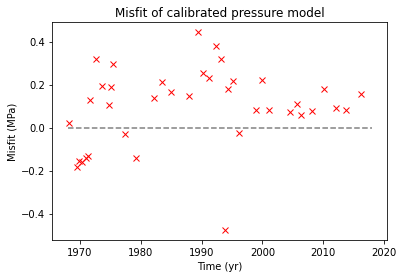

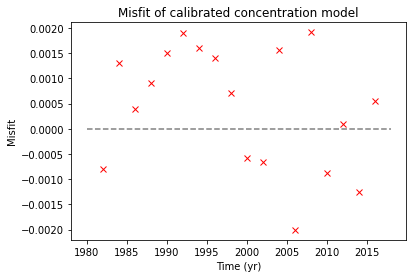

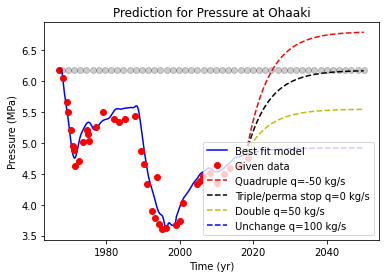

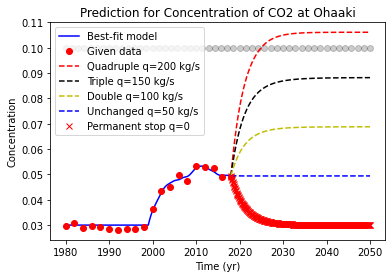

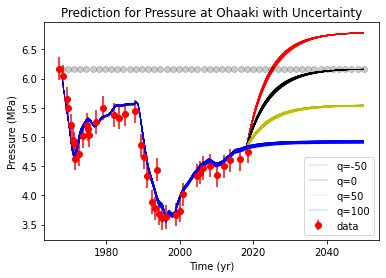

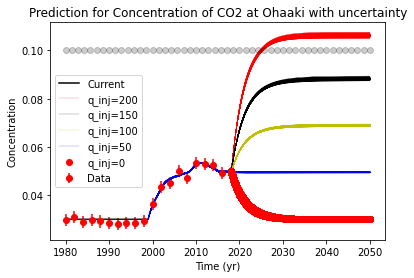

In [4]:
from matplotlib import pyplot as plt    
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

def main():
    # ---------------
    # | Interpolate |
    # ---------------

    # Set common timeline
    timeline = np.arange(1968,2018.1,0.1)

    #  Find eqn for INJECTION;
    # -------------------------
    
    tw1,yw1 = np.genfromtxt('cs_c.txt',delimiter=',',skip_header=1).T   #Read in Injection data 
    time_inj=np.arange(1999,2018.1,0.1)     #Create timeline over which data is to be interpolated
    inj_before=np.arange(1968,1999,0.1)*0   #Create an array of 0s to be the points before injection starts
    model=interp1d(tw1,yw1,kind='cubic')    #Create a cubic spline matrix set for interpolation
    
    # Interpolate over common timeline
    q_injection_plot=model(time_inj)    #Get interpolated values for desired timeline 
    q_injection = np.append(inj_before, q_injection_plot)   #Append interpolated values with array of 0s to represent full common timeline


    #  Find eqn for PRESSURE
    # ------------------------

    tw2,yw2 = np.genfromtxt('cs_p.txt',delimiter=',',skip_header=1).T   #Read in Pressure data 
    model=interp1d(tw2,yw2,kind='cubic')    #Create a cubic spline matrix set for interpolation

    # Interpolate over common timeline
    pressure = model(timeline)  #Get interpolated values for desired timeline 


    #  Find eqn for PRODUCTION
    # --------------------------

    tw3,yw3 = np.genfromtxt('cs_q.txt',delimiter=',',skip_header=1).T   #Read in Production data 
    model=interp1d(tw3,yw3,kind='cubic')    #Create a cubic spline matrix set for interpolation

    # Interpolate over common timeline
    q_production = model(timeline)   #Get interpolated values for desired timeline 


    #  Find eqn for CONCENTRAION
    # ----------------------------
   
    con_before=np.arange(1968,1980,0.1)*0+0.03
    time_con=np.arange(1980,2018.1,0.1)
    tw4,yw4 = np.genfromtxt('cs_cc.txt',delimiter=',',skip_header=1).T  #Read in Concentration data 
    model=interp1d(tw4,yw4,kind='cubic')    #Create a cubic spline matrix set for interpolation

    # Interpolate over common timeline
    concentration = np.append(con_before,model(time_con))   #Get interpolated values and add initial concentration values for the time before production 


    # ---------
    # | Given |
    # ---------

    #  Injection vs Concentration
    # ----------------------------

    f,ax1 = plt.subplots(nrows=1,ncols=1)   #Create a figure
    ax2 = ax1.twinx()   #Create a twin y-axis
    ax1.set_title('Comparision of CO2 injection rate & CO2 weight fraction in Reservoir',y=1.08)    #Set title for figure
    ax1.set_ylabel('CO2 Injection Rates (kg/s)')    #Labelling the y-axes
    ax2.set_ylabel('CO2 weight fraction in Reservior')
    ax1.set_xlabel('Year')  #Labelling the x-axis
    ax2.plot(tw4,yw4,'r',label='CO2 concentration') #Plotting interpolated models on with respect to appropriate y-axis
    ax1.plot(np.append(np.arange(1968,1998.6,0.1),tw1),np.append(np.arange(1968,1998.6,0.1)*0,yw1),'b',label='CO2 Injection') 
    ax1.legend(bbox_to_anchor=(0., 1.02, 0.5, .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)     #Creating legends for plots 
    ax2.legend(loc=2) 
    plt.savefig('Injection_VS_concentration.png',dpi=300)   #Saving the figure


    #  Extraction vs Pressure 
    # ------------------------

    f,ax1 = plt.subplots(nrows=1,ncols=1)    #Create a figure
    ax2 = ax1.twinx()   #Create a twin y-axis
    ax1.set_title('Comparision of extraction/injection rate & Pressure in Reservoir',y=1.08)    #Set title for figure
    ax1.set_ylabel('Mass Rates (kg/s)')     #Labelling the y-axes 
    ax2.set_ylabel('Pressure (MPa)')
    ax1.set_xlabel('Year')  #Labelling the x-axis
    ax2.plot(tw2,yw2,'k--',label='Pressure')       #Plotting interpolated models on with respect to appropriate y-axis
    ax1.plot(np.append(np.arange(1968,1998.6,0.1),tw1),np.append(np.arange(1968,1998.6,0.1)*0,yw1),'r',label='Injection') 
    ax1.plot(tw3,yw3,'b',label='Extraction')
    ax1.legend(bbox_to_anchor=(0., 1.02, 0.5, .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)     #Creating legends for plots
    ax2.legend(loc=2) 
    plt.savefig('MassRate_VS_Pressure.png',dpi=300)     #Saving the figure




    # ----------------
    # | Benchmarking |
    # ----------------

    #Setting constants and parameters 
    q_pressure = q_production - q_injection
    dt = timeline[1]-timeline[0]
    dqdt = np.gradient(q_pressure, dt)
    a = 3e-3
    b = 2.26e-1
    c = 3.56e-5

    #Solving Pressure model numerically 
    numerical_x,numerical_y=solve_ode(ode_model_pressure,1968,2018,0.1,6.17,[q_pressure, a, b, 6.17, c, dqdt])

    #Analytically solved Pressure, benchmarking
    analytical_p=pressure_analytical(timeline,6.17,a,b,c)
    y=[150, 150]
    t=[1968, 2018]
    q_model=interp1d(t,y,kind='linear')
    dqdt_model = np.gradient(q_model(timeline), dt)
    t_benchmarking,P_benchmarking=solve_ode(ode_model_pressure,1968,2018,0.1,6.17,[q_model(timeline), a, b, 6.17, c, dqdt_model])
    
    #Compare with numerical
    f,ax1 = plt.subplots(nrows=1,ncols=1)   #Create a figure
    ax1.set_ylabel('Pressure (MPa)')     #Labelling the y-axis 
    ax1.set_xlabel('Time (yr)')      #Labelling the x-axis 
    ax1.plot(t_benchmarking, P_benchmarking, 'r', label='Numerical')    #Plotting Numerical Solution 
    ax1.plot(t_benchmarking, analytical_p, 'bx', label='Analytical', alpha=0.2)     #Plotting Analytical Solution
    ax1.legend()    #Displaying Legend for Figure 
    ax1.set_title('Benchmarking for Pressure ODE')  #Setting Title for figure 
    plt.savefig('Pressure_Benchmarking.png')    #Saving the figure 

    #Step size test
    h=np.linspace(0.01,5, num=200) #Creating an array of step sizes to test
    P_step=[] #Blank array to store test values
    for i in h:
        nx = int(np.ceil((2000-1968)/i))
        t = 1968+np.arange(nx+1)*i
        q_1=q_model(t)
        dqdt_model_1 = np.gradient(q_model(t), i)
        time,P=solve_ode(ode_model_pressure,1968,2000,i,6.17,[q_1, a, b, 6.17, c, dqdt_model_1])
        P_step.append(P[-1])
    
    #Convergence
    f,ax1 = plt.subplots(nrows=1,ncols=1) #Create a figure
    ax1.set_ylabel('Pressure at 2000 (MPa)') #Labelling the y-axis
    ax1.set_xlabel('Step size h (yr)') #Labelling the x-axis 
    ax1.plot(h,P_step, 'r', label='Modelled data') #Plot values against step sizes
    ax1.set_title('Convergence test with different time step') #Setting Title for figure 
    plt.savefig('Pressure_Convergence.png')  #Saving the figure

    #Concentration, all parameters are made up
    q=q_injection[0]
    M=8000
    P=numerical_y[0]
    P0=numerical_y[0]
    d=0.3
    C0=0.03
    pars=[q,M,a,b,P,P0,d,C0]

    #Analytically solved concentration, benchmarking 
    #Assume q is constant at 50kg/s 
    q_injection_model=0.*np.array(q_injection)+50
    q=q_injection_model[0]
    tC_benchmarking,C_benchmarking=solve_ode_concentration(ode_model_concentration, 1968, 2018, 0.1, C0, q_injection_model, analytical_p, pars)
    analytical_C = concentration_analytical(numerical_x,q_injection_model,M,a,b,analytical_p,6.17,d,C0)

    #Compare with numerical
    f,ax1 = plt.subplots(nrows=1,ncols=1)   #Create a figure
    ax1.plot(tC_benchmarking, C_benchmarking, 'r', label='Numerical')   #Plotting Numerical Solution
    ax1.plot(numerical_x, analytical_C, 'bx', label='Analytical', alpha=0.2)     #Plotting Analytical Solution
    ax1.legend()    #Displaying Legend for Figure 
    ax1.set_ylabel('Concentration of CO2')  #Labelling the y-axis
    ax1.set_xlabel('Time (yr)')     #Labelling the x-axis 
    ax1.set_title('Benchmarking for Concentration ODE')     #Setting Title for figure  
    plt.savefig('Concentration_Benchmarking.png')   #Saving the figure

    #Step size test
    h=np.linspace(0.001,5, num=200) #Creating an array of step sizes to test
    C_step=[]   #Blank array to store test values
    for i in h:
        nx = int(np.ceil((1990-1968)/i))
        t = 1968+np.arange(nx+1)*i
        q_1=q_model(t)
        dqdt_model_1 = np.gradient(q_model(t), i)
        q_injection_model=0.*np.array(t)+50
        time,P_con=solve_ode(ode_model_pressure,1968,1990,i,6.17,[q_1, a, b, 6.17, c, dqdt_model_1])
        time,C_1990=solve_ode_concentration(ode_model_concentration, 1968, 1990, i, C0, q_injection_model, P_con, pars)
        C_step.append(C_1990[-1])

    #Convergence
    f,ax1 = plt.subplots(nrows=1,ncols=1)   #Create a figure
    ax1.set_ylabel('Concentration at 1990')  #Labelling the y-axis
    ax1.set_xlabel('Step size h (yr)')   #Labelling the x-axis 
    ax1.plot(h,C_step, 'r', label='Modelled data') #Plot values against step sizes
    ax1.set_title('Convergence test with different time step') #Setting Title for figure  
    plt.savefig('Concentration_Convergence.png') #Saving the figure


    # ---------------
    # | Calibration |
    # ---------------

    #  curve_fit Calibration for PRESSURE ODE
    # ----------------------------------------

    # initial guess for parameters based on literature (Fradkin et al 1981)
    P_guess = np.array([0.01, 0.39, 1.3])

    # use curve fit to calibrate parameters a, b and c
    abc_calibrated, P_covariance = curve_fit(lambda cf_t,a_parm,b_parm,c_parm: cf_solve_ode_pressure(cf_t, timeline[0], timeline[-1], dt, pressure[0], q_pressure, dqdt, a_parm, b_parm, c_parm), timeline, pressure, p0=P_guess)
    
    #print(abc_calibrated) # uncomment to check parameter values
    #print(P_covariance) # uncomment to print covariance matrix

    # plot pressure model against pressure data
    f,ax1 = plt.subplots(nrows=1,ncols=1)   #Create a figure
    ax1.plot(tw2,yw2, 'ro', label='Given data') # Plot the given data for pressure
    ax1.plot(timeline, cf_solve_ode_pressure(timeline, timeline[0], timeline[-1], dt, pressure[0], q_pressure, dqdt, abc_calibrated[0], abc_calibrated[1], abc_calibrated[2]), 'b', label='Model')  #Plot calibrated model
    ax1.set_title('Pressure ODE: data vs. model comparison')    #Set Figure title 
    ax1.set_ylabel('Pressure (MPa)')    #Labelling y-axis
    ax1.set_xlabel('Time (yr)') #Labelling x-axis
    ax1.legend()    #Displaying Legend 
    plt.savefig('Pressure_Calibration.png')  #Saving the figure 


    #  curve_fit calibration CONCENTRATION ODE
    # -----------------------------------------

    # use pressure model to get solution for pressure values
    P_model = cf_solve_ode_pressure(timeline, timeline[0], timeline[-1], dt, pressure[0], q_pressure, dqdt, abc_calibrated[0], abc_calibrated[1], abc_calibrated[2])

    # initial guess for d and M0 (educated-ish guess)
    C_guess = np.array([3*10**7, 0.3]) 

    # use curve fit to calibrate parameters M0 and d
    M0d_calibrated, C_covariance = curve_fit(lambda cf_t,M0_parm,d_parm: cf_solve_ode_concentration(cf_t, timeline[0], timeline[-1], dt, concentration[0], q_injection, P_model, M0_parm, abc_calibrated[0], abc_calibrated[1], pressure[0], d_parm), timeline, concentration, p0=C_guess)
    
    #print(M0d_calibrated) # uncomment to check parameter values
    #print(M0d_covariance) # uncomment to print covariance matrix

    # plot pressure model against Concentration data
    f,ax1 = plt.subplots(nrows=1,ncols=1)   #Create a figure
    ax1.plot(tw4, yw4, 'ro', label='Given data')    # Plot the given data for concentration 
    ax1.plot(timeline, cf_solve_ode_concentration(timeline, timeline[0], timeline[-1], dt, concentration[0], q_injection, P_model, M0d_calibrated[0], abc_calibrated[0], abc_calibrated[1], pressure[0], M0d_calibrated[1]), 'b', label='Model')    #Plot calibrated model
    ax1.set_title('CO2 Concentration ODE: data vs. model comparison')
    ax1.set_ylabel('Concentration') #Labelling y-axis
    ax1.set_xlabel('Time (yr)') #Labelling x-axis
    ax1.legend()   #Displaying Legend  
    plt.savefig('Concentration_Calibration.png')    #Saving the figure

    # using calibrated parameters to find pressure and concentration values according to model:
    #Pressure
    thetaP=[abc_calibrated[0], abc_calibrated[1], abc_calibrated[2]] # get calibrated a, b and c values
    time,P_calibrated=solve_ode(ode_model_pressure,1968,2018,0.1,6.17,[q_pressure, thetaP[0], thetaP[1], 6.17, thetaP[2], dqdt]) # solve for pressure

    #Concentration
    thetaC=[M0d_calibrated[0], M0d_calibrated[1]] # get calibrated M0 and d values
    P_concentration=P_calibrated[np.where(time == 1980)[0][0]:np.where(time == 2018)[0][0]+1] # modify pressure values to fit concentration timeline
    q_injection=q_injection[np.where(time == 1980)[0][0]:np.where(time == 2018)[0][0]+1] # modify injection values to fit concentration timline
    time_C,C_calibrated=solve_ode_concentration(ode_model_concentration, 1980, 2018, 0.1, C0, q_injection, P_concentration, [q_injection[0],thetaC[0],thetaP[0],thetaP[1],P_calibrated[-1],P0,thetaC[1],C0]) # solve for concentration
    
    # ----------
    # | Misfit |
    # ----------

    #Pre-allocate list to store misfit
    misfitP_time=[]
    misfitP=[]
    #loop through the data
    for i in range(1,len(tw2)-1):
        #find the index where calibrated data matches with given data 
        j=np.where(np.round(time,decimals=1) == np.round(tw2[i],decimals=1))[0][0]

        #misfit
        misfitP.append(P_calibrated[j]-yw2[i])

        #store
        misfitP_time.append(time[j])

    #Graph and save plot
    f,ax1 = plt.subplots(nrows=1,ncols=1)
    ax1.set_ylabel('Misfit (MPa)')
    ax1.set_xlabel('Time (yr)')
    ax1.plot(misfitP_time, misfitP, 'rx', label='Misfit')
    ax1.plot(np.linspace(1968,2018),np.linspace(1968,2018)*0, 'k--', alpha=0.5)
    ax1.set_title('Misfit of calibrated pressure model')
    plt.savefig('Pressure_Misfit.png')

    #Pre-allocate list to store misfit
    misfitC_time=[]
    misfitC=[]

    for i in range(1,len(tw4)-1):
        #find the index where calibrated data matches with given data 
        j=np.where(np.round(time_C,decimals=1) == np.round(tw4[i],decimals=1))[0][0]

        #misfit
        misfitC.append(C_calibrated[j]-yw4[i])

        #store
        misfitC_time.append(time_C[j])

    #Graph and save plot
    f,ax1 = plt.subplots(nrows=1,ncols=1)   #Create a figure
    ax1.set_ylabel('Misfit')    #Labelling the y-axis
    ax1.set_xlabel('Time (yr)')  #Labelling the x-axis
    ax1.plot(misfitC_time, misfitC, 'rx', label='Misfit') 
    ax1.plot(np.linspace(1980,2018),np.linspace(1980,2018)*0, 'k--', alpha=0.5)
    ax1.set_title('Misfit of calibrated concentration model') #Setting Title for figure  
    plt.savefig('Concentration_Misfit.png')    #Saving the figure
    
    # --------------
    # | Prediction |
    # --------------

    #  Predictions for pressure
    # --------------------------
    
    #Quadrupling Injection
    y=[-50, -50]
    t=[2018, 2050] #prediction time 
    #Interpolate
    q_model=interp1d(t,y,kind='linear')
    timeline_prediction=np.arange(2018,2050.1,0.1)
    q_1=q_model(timeline_prediction)
    dqdt_model_1 = np.gradient(q_1, 0.1)
    t_prediction,P_prediction_1=solve_ode(ode_model_pressure,2018,2050,0.1,P_calibrated[-1],[q_1, thetaP[0], thetaP[1], 6.17, thetaP[2], dqdt_model_1])

    #Triple, and permanent stop
    y=[0, 0] 
    q_model=interp1d(t,y,kind='linear')
    q_1=q_model(timeline_prediction)
    dqdt_model_1 = np.gradient(q_1, 0.1)
    t_prediction,P_prediction_2=solve_ode(ode_model_pressure,2018,2050,0.1,P_calibrated[-1],[q_1, thetaP[0], thetaP[1], 6.17, thetaP[2], dqdt_model_1])

    #Doubling Injection
    y=[50, 50] 
    q_model=interp1d(t,y,kind='linear')
    q_1=q_model(timeline_prediction)
    dqdt_model_1 = np.gradient(q_1, 0.1)
    t_prediction,P_prediction_3=solve_ode(ode_model_pressure,2018,2050,0.1,P_calibrated[-1],[q_1, thetaP[0], thetaP[1], 6.17, thetaP[2], dqdt_model_1])

    #Unchanged Injection
    y=[100, 100] 
    q_model=interp1d(t,y,kind='linear')
    q_1=q_model(timeline_prediction)
    dqdt_model_1 = np.gradient(q_1, 0.1)
    t_prediction,P_prediction_4=solve_ode(ode_model_pressure,2018,2050,0.1,P_calibrated[-1],[q_1, thetaP[0], thetaP[1], 6.17, thetaP[2], dqdt_model_1])

    #Graph
    f,ax1 = plt.subplots(nrows=1,ncols=1)   #Create a figure
    ax1.set_ylabel('Pressure (MPa)')    #Labelling y-axis
    ax1.set_xlabel('Time (yr)')     #Labelling x-axis
    ax1.plot(time, P_calibrated, 'b', label='Best fit model')
    ax1.plot(tw2, yw2, 'ro', label='Given data') 
    ax1.plot(np.linspace(1968,2050),np.linspace(1968,2050)*0+6.17, 'ko', alpha=0.2)
    ax1.plot(t_prediction,P_prediction_1, 'r--', label='Quadruple q=-50 kg/s')
    ax1.plot(t_prediction,P_prediction_2, 'k--', label='Triple/perma stop q=0 kg/s')
    ax1.plot(t_prediction,P_prediction_3, 'y--', label='Double q=50 kg/s')
    ax1.plot(t_prediction,P_prediction_4, 'b--', label='Unchange q=100 kg/s')
    ax1.set_title('Prediction for Pressure at Ohaaki')  #Setting Title for figure  
    ax1.legend(loc=4)   #Displaying Legend for Figure 
    plt.savefig('Pressure_Predictions.png') #Saving Figure


    #  Predictions for Concentration
    # ------------------------------

    #Quadrupling Injection
    y=[200, 200]
    q_model=interp1d(t,y,kind='linear')
    q_1=q_model(timeline_prediction)
    t_prediction,C_prediction_1=solve_ode_concentration(ode_model_concentration, 2018, 2050, 0.1, C_calibrated[-1], q_1, P_prediction_1, [200,thetaC[0],thetaP[0],thetaP[1],P_calibrated[-1],P0,thetaC[1],C0])
    
    #Tripling Injection
    y=[150, 150] 
    q_model=interp1d(t,y,kind='linear')
    q_1=q_model(timeline_prediction)
    t_prediction,C_prediction_2=solve_ode_concentration(ode_model_concentration, 2018, 2050, 0.1, C_calibrated[-1], q_1, P_prediction_2, [150,thetaC[0],thetaP[0],thetaP[1],P_calibrated[0],P0,thetaC[1],C0])
    
    #Doubling Injection
    y=[100, 100] 
    q_model=interp1d(t,y,kind='linear')
    q_1=q_model(timeline_prediction)
    t_prediction,C_prediction_3=solve_ode_concentration(ode_model_concentration, 2018, 2050, 0.1, C_calibrated[-1], q_1, P_prediction_3, [100,thetaC[0],thetaP[0],thetaP[1],P_calibrated[0],P0,thetaC[1],C0])

    #Unchanged Injection 
    y=[50, 50] 
    q_model=interp1d(t,y,kind='linear')
    q_1=q_model(timeline_prediction)
    t_prediction,C_prediction_4=solve_ode_concentration(ode_model_concentration, 2018, 2050, 0.1, C_calibrated[-1], q_1, P_prediction_4, [50,thetaC[0],thetaP[0],thetaP[1],P_calibrated[0],P0,thetaC[1],C0])
    
    #Permanent stop to Injection
    y=[0, 0] 
    q_model=interp1d(t,y,kind='linear')
    q_1=q_model(timeline_prediction)
    t_prediction,C_prediction_5=solve_ode_concentration(ode_model_concentration, 2018, 2050, 0.1, C_calibrated[-1], q_1, P_prediction_2, [0,thetaC[0],thetaP[0],thetaP[1],P_calibrated[0],P0,thetaC[1],C0])
    
    #Graph
    f,ax1 = plt.subplots(nrows=1,ncols=1)    #Create a figure
    ax1.set_ylabel('Concentration')     #Labelling y-axis
    ax1.set_xlabel('Time (yr)')     #Labelling x-axis
    ax1.plot(time_C, C_calibrated, 'b', label='Best-fit model')
    ax1.plot(tw4, yw4, 'ro', label='Given data')
    ax1.plot(np.linspace(1980,2050),np.linspace(1980,2050)*0+0.1, 'ko', alpha=0.2)
    ax1.plot(t_prediction,C_prediction_1, 'r--', label='Quadruple q=200 kg/s')
    ax1.plot(t_prediction,C_prediction_2, 'k--', label='Triple q=150 kg/s')
    ax1.plot(t_prediction,C_prediction_3, 'y--', label='Double q=100 kg/s')
    ax1.plot(t_prediction,C_prediction_4, 'b--', label='Unchanged q=50 kg/s')
    ax1.plot(t_prediction,C_prediction_5, 'rx', label='Permanent stop q=0')
    ax1.set_title('Prediction for Concentration of CO2 at Ohaaki')  #Setting Title for figure 
    ax1.legend()    #Displaying Legend for Figure
    plt.savefig('Concentration_Predictions.png')    #Saving Figure


    # --------------------------
    # | Uncertainty: Posterior | 
    # --------------------------

    #Pre-allocate list to store data 
    q_posterior=[] #store for latter used in concentration
    dqdt_posterior=[] #store for latter used in concentration
    P_upperbound=[] #5,95
    P_lowerbound=[]

    #Create a plot
    f,ax =plt.subplots(1,1)

    #List of rates q=q_ext-q_inj
    rate_net=[-50,0,50,100,0]

    #Pre-allocate colours 
    s=['r-','k-','y-','b-','ro'] #colour
    for i in range(len(rate_net)):
        #Interpolate constant rate 
        y=[rate_net[i], rate_net[i]]
        q_model=interp1d(t,y,kind='linear')

        #store
        q_posterior.append(q_model(timeline_prediction))
        dqdt_posterior.append(np.gradient(q_posterior[i], 0.1))

        #solve to get t_Pos
        t_pos,P_post=solve_ode(ode_model_pressure,1968,2018,0.1,6.17,[q_pressure, thetaP[0], thetaP[1], 6.17, thetaP[2], dqdt])

        #Create N number of samples
        N=1000
        samples = construct_samples_pressure(thetaP, P_covariance, N)

        #Solve model with all samples 
        P_set=model_ensemble_pressure(samples,np.append(q_pressure,q_posterior[i]),np.append(dqdt,dqdt_posterior[i]),pressure[0])

        #record steady state solution
        P_last=[]
        for j in range(len(P_set)):
            P_last.append(P_set[j][-1])
            #Graph
            if (i==4) is False:
                ax.plot(np.append(t_pos,timeline_prediction[1:]),P_set[j],s[i], label='q={}'.format(rate_net[i]),lw=0.2)
        
        #store
        P_upperbound.append(np.max(P_last))
        P_lowerbound.append(np.min(P_last))
    

    #print(P_upperbound) # uncomment to print upperbound of pressure prediction
    #print(P_lowerbound) # uncomment to print lowerbound of pressure prediction

    #Given data with error bars
    ax.errorbar(tw2,yw2,yerr=0.2,fmt='ro', label='data')

    #Modify the legend ref: https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
    handles, labels = ax.get_legend_handles_labels()
    handle_list, label_list = [], []
    for handle, label in zip(handles, labels):
        if label not in label_list:
            handle_list.append(handle)
            label_list.append(label)

    plt.legend(handle_list, label_list)

    #Pre-exploitation pressure 
    ax.plot(np.linspace(1968,2050),np.linspace(1968,2050)*0+6.17, 'ko', alpha=0.2)

    #Title and labels 
    ax.set_title('Prediction for Pressure at Ohaaki with Uncertainty')
    ax.set_ylabel('Pressure (MPa)')
    ax.set_xlabel('Time (yr)')
    plt.savefig('Pressure_Predictions_Uncertainty.png')

    #concentration 
    #pre-allocation
    C_upperbound=[]
    C_lowerbound=[]

    #create a plot
    f,ax =plt.subplots(1,1)

    #calibrated model
    ax.plot(time_C, C_calibrated, 'k-', label='Current')

    #rate of injection
    rate=[200,150,100,50,0]

    for i in range(len(rate)):
        #interpolate constant rate over time t
        y=[rate[i], rate[i]]
        q_model=interp1d(t,y,kind='linear')
        q_inj_posterior=q_model(timeline_prediction)

        #Solve for corresponding pressure
        t_useless,P_prediction_posterior=solve_ode(ode_model_pressure,2018,2050,0.1,P_calibrated[-1],[q_posterior[i], thetaP[0], thetaP[1], 6.17, thetaP[2], dqdt_posterior[i]])

        #Create N number of samples 
        N=1000
        samples = construct_samples_concentration(thetaC,C_covariance , N)

        #Solve the model with N samples
        C_set=model_ensemble_concentration(samples,np.append(q_injection,q_inj_posterior),np.append(P_concentration,P_prediction_posterior)) #from 1980 to 2050
        
        #Record steady solution
        C_last=[]
        for j in range(len(C_set)):
            C_last.append(C_set[j][-1])
            #Graph
            if i==4:
                ax.plot(timeline_prediction[1:],C_set[j][np.where(np.round(np.arange(1980,2050.1,0.1),decimals=1)==timeline_prediction[1])[0][0]:],s[i], label='q_inj={}'.format(rate[i]),lw=0.2)
            else:
                ax.plot(np.append(time_C,timeline_prediction[1:]),C_set[j],s[i], label='q_inj={}'.format(rate[i]),lw=0.2)
        
        #Store upper and lowerbound
        C_upperbound.append(np.max(C_last))
        C_lowerbound.append(np.min(C_last))

    #print(C_upperbound) #uncomment to print upperbounds for concentration predictions
    #print(C_lowerbound) #uncomment to print lowerbounds for concentration predictions
    
    #Given data with error bar 
    ax.errorbar(tw4,yw4,yerr=0.0025,fmt='ro', label='Data')

    #Modify the legend
    handles, labels = ax.get_legend_handles_labels()
    handle_list, label_list = [], []
    for handle, label in zip(handles, labels):
        if label not in label_list:
            handle_list.append(handle)
            label_list.append(label)
    plt.legend(handle_list, label_list)

    #10% line
    ax.plot(np.linspace(1980,2050),np.linspace(1980,2050)*0+0.1, 'ko', alpha=0.2)

    #Title and labels
    ax.set_title('Prediction for Concentration of CO2 at Ohaaki with uncertainty')
    ax.set_ylabel('Concentration')
    ax.set_xlabel('Time (yr)')
    plt.savefig('Concentration_Predictions_Uncertainty.png')

if __name__ == "__main__":
    main()
